In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from uatu.scattering import *

In [5]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [6]:
model_path = '/home/sean/Git/uatu/networks/deep_resnet_quijote_50_adv.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_clone.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_adv_clone.pth'

In [7]:
#downsample_factor = 4
shape = (128, 128)
in_channels = 1
width = 2

depth = 5#[16, 32, 64, 64, 64, 64, 64]

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [10]:
model = DeepResnet(input_size = shape[0],init_downsample_factor = 2, in_channels=in_channels, n_subplanes=width, depth=depth).to(device)

In [11]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [12]:
model.eval()

DeepResnet(
  (init_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=64)
  )
  (layer_0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), 

In [45]:
def log_barrier(x_p, x_o, eps=1., lam=1e2):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=2) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [14]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#
    x = model.init_conv(x)

    for l in model.layers:
        x = l(x)

    #x = model.avgpool(x)
    #x = x.view(x.size(0), -1)
    #x = model.fc(x)
    return x

In [15]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [17]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [18]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [32]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =1e-4
    # TODO figure out how to use one of these here... 
    for i in range(2500):
        optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

        optimizer.zero_grad()

        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        optimizer.step()

        # Collect datagrad

        #x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.8
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        #perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        #perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [33]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [34]:
mean, std = 0, 1
smooth = 0

In [35]:
f = h5py.File('../data/UatuQuijoteTest.hdf5', 'r')
#for boxno in xrange(5):
boxno = 3
target_boxno = 4
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [36]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [37]:
target_X_mean = target_X.mean(axis = 0)
R = ((target_X-target_X_mean)**2).mean(axis = 0)
target_X_std = np.sqrt(R) # cov too bign

In [38]:
n_orig = 2 #201#100 
n_targ = 24#n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
#Y = np.tile(Y, (batch_size, 1))

In [39]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

clone_targ_X = target_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

#targ_X = (targ_X-mean)/(std)

In [40]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [41]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [42]:
cmap = ConvergenceMap(gaussian_filter(targ_X.squeeze(), smooth), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

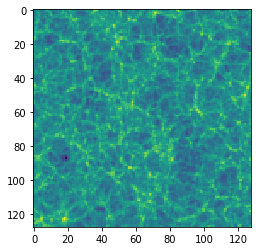

In [43]:
plt.imshow(X.squeeze())

tensor(188.3448, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 8e-05


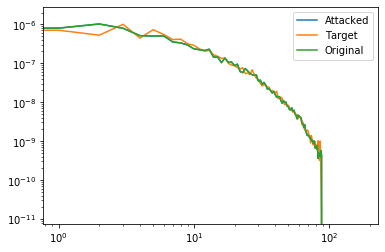

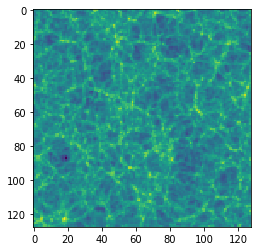

tensor(188.3085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.2795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.2505, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.2215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.1925, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.1635, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.1346, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.1056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.0767, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.0478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(188.0189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.9901, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.9612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.9324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.9035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.8745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.8456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(187.816

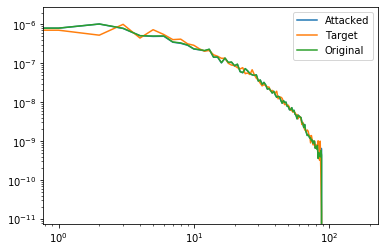

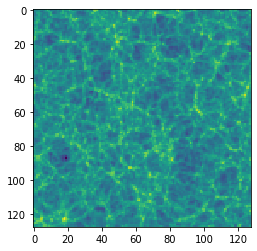

tensor(185.4535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.4354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.4181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.4011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3674, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3177, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.3014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2851, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2210, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.2053, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.1896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(185.174

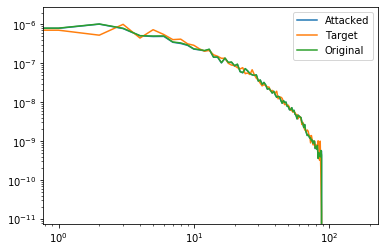

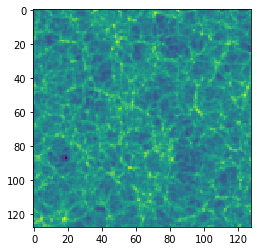

tensor(184.4438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.4384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.4310, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.4225, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.4137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.4048, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3535, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3452, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.3138, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.307

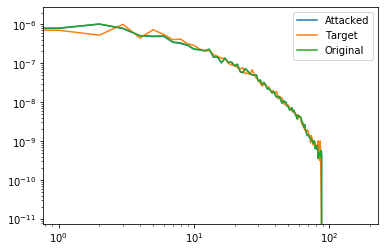

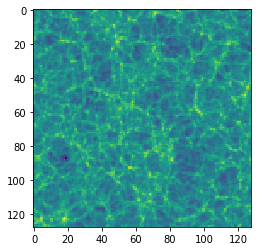

tensor(184.2474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2399, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2285, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2227, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2168, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.2050, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1821, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1766, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1666, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.1615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.158

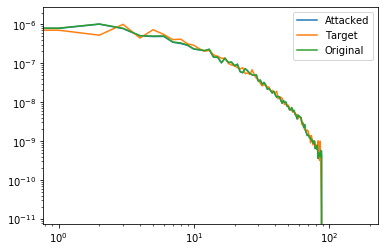

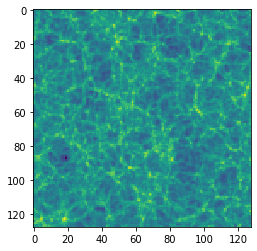

tensor(184.0896, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0892, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0847, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0804, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0760, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0718, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0510, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0400, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0361, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0334, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.0296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(184.027

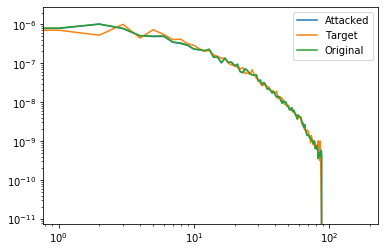

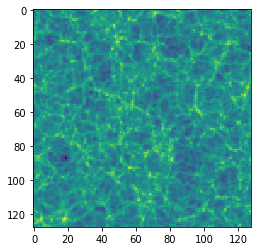

tensor(183.8973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8977, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8884, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8745, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8723, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8695, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8601, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.8582, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.855

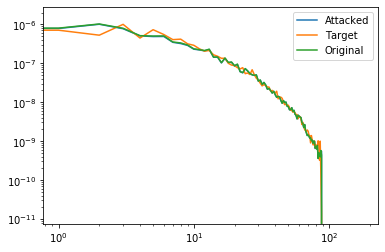

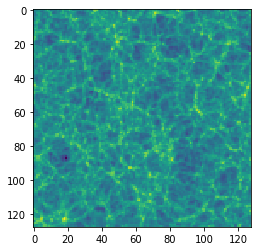

tensor(183.7261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7236, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7159, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7140, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7098, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.7004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.698

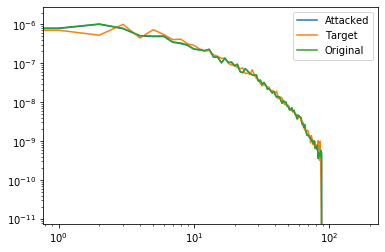

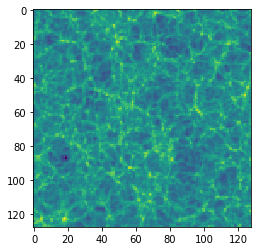

tensor(183.6060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.6045, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.6033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.6025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.6013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.6013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5970, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5950, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5924, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5913, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.589

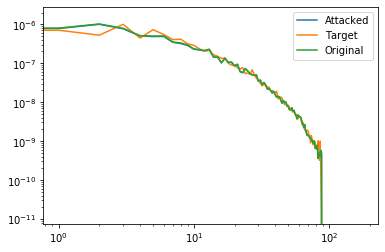

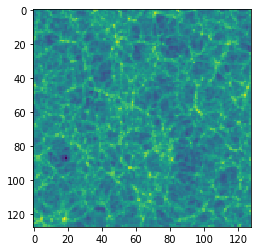

tensor(183.5253, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5241, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5233, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5222, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5197, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5197, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5186, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5178, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5168, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5161, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.5147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.514

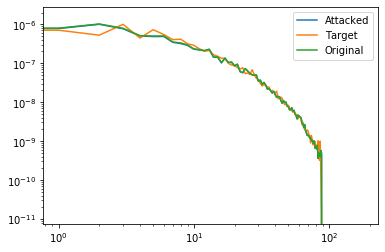

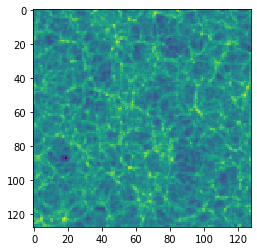

tensor(183.4685, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4682, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4676, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4673, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4667, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4649, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4636, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4635, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4628, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.461

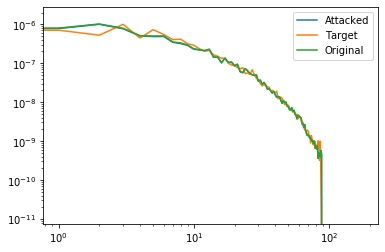

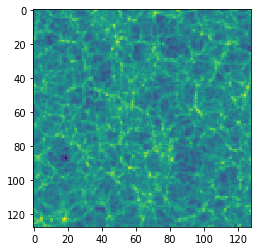

tensor(183.4288, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4286, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4282, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4273, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4270, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4269, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4252, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4251, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4243, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4242, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.423

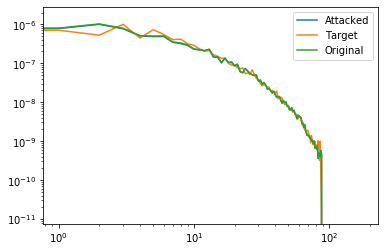

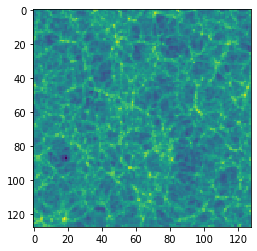

tensor(183.4007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.4000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3994, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3993, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3990, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3981, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3978, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3975, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3973, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3970, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.396

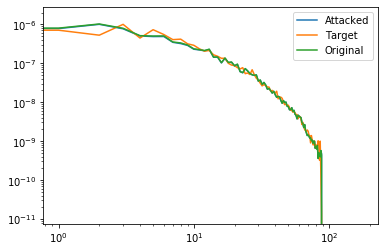

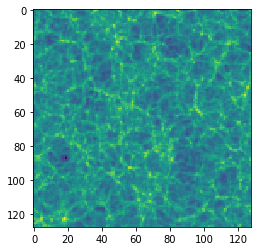

tensor(183.3803, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3800, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3799, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3794, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3791, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3789, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3788, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3786, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3785, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3784, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3782, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3780, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3779, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.377

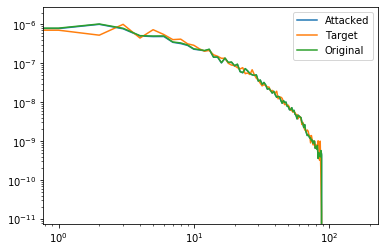

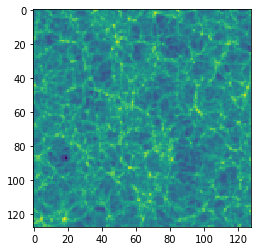

tensor(183.3661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3655, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3652, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3651, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3648, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3644, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.364

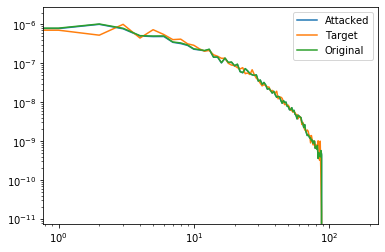

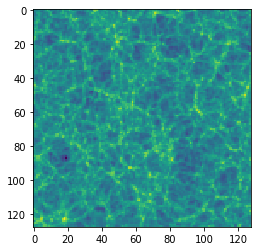

tensor(183.3556, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3554, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3553, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3552, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3547, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3546, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3543, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.354

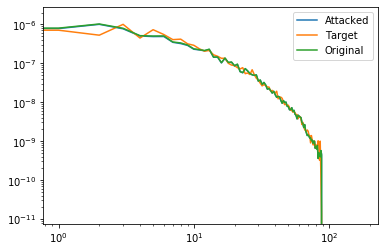

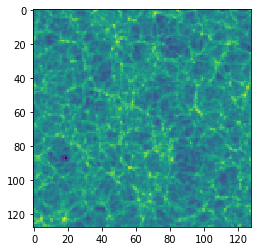

tensor(183.3479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3477, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3472, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.346

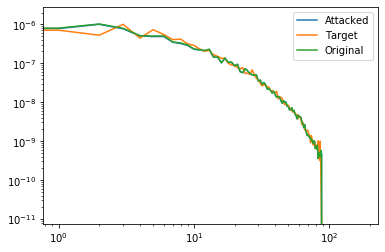

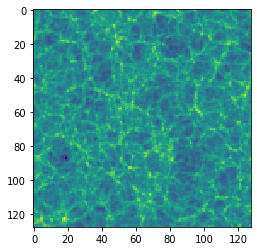

tensor(183.3421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3419, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3417, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3416, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3415, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3415, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3413, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.341

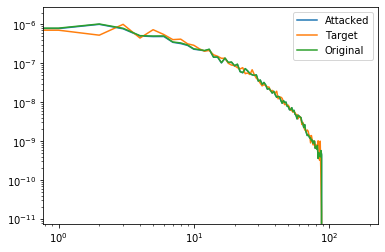

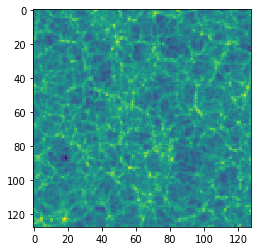

tensor(183.3375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3373, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3371, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.336

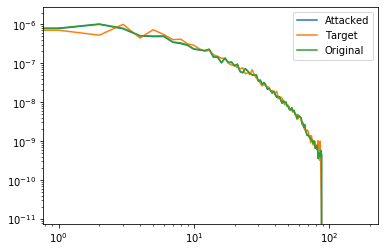

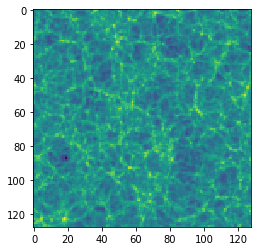

tensor(183.3341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3338, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3337, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3336, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.333

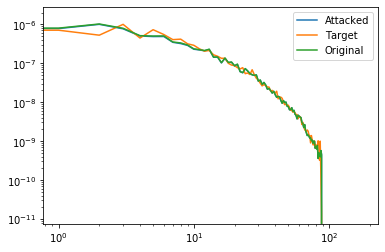

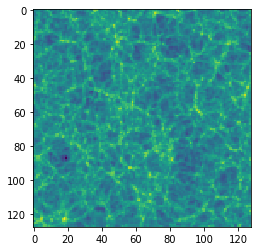

tensor(183.3314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3314, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3313, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.331

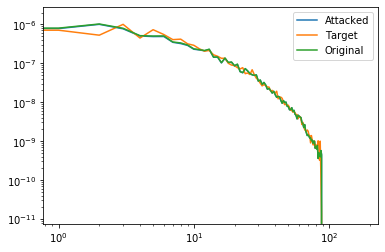

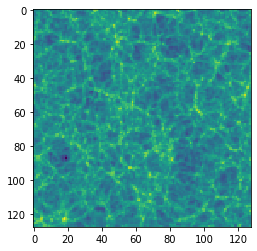

tensor(183.3294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3291, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.329

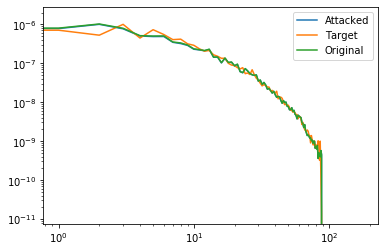

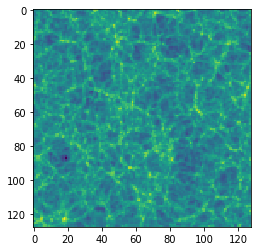

tensor(183.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3278, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3277, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3276, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.327

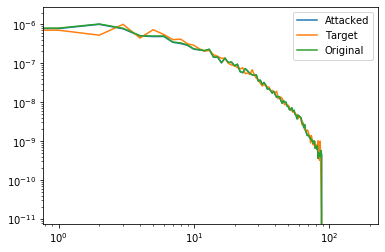

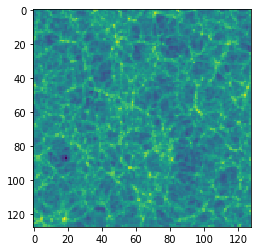

tensor(183.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3265, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.326

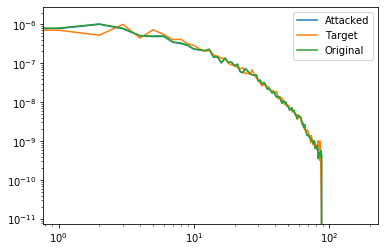

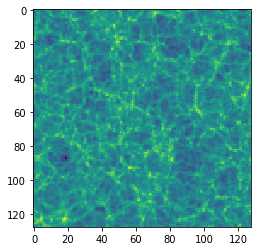

tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3255, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.325

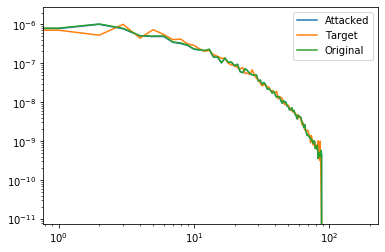

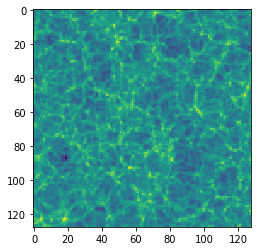

tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3248, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.3247, device='cuda:0', grad_fn=<AddBackward0>)
tensor(183.324

In [46]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(gaussian_filter(targ_X,smooth)).reshape((1, shape[0], shape[1])) )#,\

In [47]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [48]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [49]:
print(np.linalg.norm(init_embed-robust_embed))

183.26314


In [50]:
X_robust.max(), X.max()

(1.6449616, 1.6683317422866821)

In [51]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [52]:
target_Y

array([[0.3175, 0.819 ]])

In [53]:
model(scattering(torch.Tensor(gaussian_filter(targ_X.reshape((1, shape[0], shape[1])), 0)).to('cuda'))).to('cpu').detach().numpy()

array([[0.31949887, 0.83928245]], dtype=float32)

In [54]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.32096884, 0.83667606]], dtype=float32)

In [55]:
model(scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.3210527, 0.8382391]], dtype=float32)

In [56]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [57]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(66.037506, 65.732864)

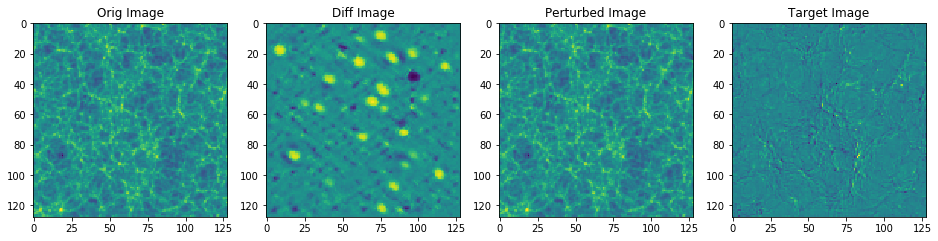

In [58]:
fig = plt.figure(figsize = (16,4))
plt.subplot(141)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(142)
plt.title('Diff Image')
plt.imshow(X_robust.squeeze()-X.squeeze() )#, vmin = 0.01*vmin, vmax= 0.01*vmax)
plt.subplot(143)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(144)
plt.title('Target Image')
plt.imshow(clone_targ_X.squeeze()-X.squeeze())#, vmin = vmin, vmax= vmax)

In [ ]:
size = 1
orig_peaks = count_peaks(X.squeeze(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(gaussian_filter(targ_X.squeeze(), smooth), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

In [ ]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(gaussian_filter(targ_X.flatten(), smooth), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [ ]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(gaussian_filter(targ_X.squeeze(), smooth))
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

In [ ]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();